In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

In [45]:
class Cloth:
    def __init__(self, static_pts, N=16, kT=1e-3, thresh=0.01):
        # Initialize constants/input parameters
        self.static_pts = static_pts
        self.thresh = thresh
        self.end_flag = False
        self.N = N  # Number of masses per side.
        self.k = 50  # Spring constant
        self.length = 1  # Spring equilibrium length
        self.z = 1  # starting z position of the cloth
        self.m = .04  # Mass, almost looks like a density in the limit of N -> inf
        self.sigma = .25 * self.length  # This is standard deviation of the gaussian region sampled for perturbations.
        self.g = 9.8  # gravitational acceleration, note sign!
        self.kT = kT  # Temperature appearing in Boltzmann factor, this should be changed through runs.
        self.E = 0  # Initial energy
        self.step = 0  # Starting mc steps
        self.E_data = list()  # Track energy over time
        self.E_per_particle = list() # track energy per particle over time
        self.E_per_particle.append(self.E / self.N**2)
        self.E_data.append(self.E)  # Add starting energy to data
        self.E_change = list()

        # Initialize lattice. Lattice is a dictionary with coordinate tuple (i, j) as the key
        # with 3D coordinates np array [x_points, y, z] as the position.
        self.lattice = dict()
        for i in range(0, self.N):
            for j in range(0, self.N):
                self.lattice[(i, j)] = np.array([i * self.length, j * self.length, self.z], dtype=np.float64)

    def simulate(self):
        """ Runs the simulation until the threshold condition is met """
        while not self.end_flag:
            self.do_mcmc_step()
        print(f'Simulation finished after {self.step} MCMC steps')

    def simulate_with_cooling(self, n_cooling_steps=3):
        """ Takes in an integer which tells the simulation how many cooling steps to take. Each time that
            the simulation reaches equilibrium, the temperature is halved until the total number of cooling
            steps is reached. The function outputs a dict of the cloth position at each temperature's
            equilibrium """
        cooling_step = 0
        equilibrium_data = dict()
        while cooling_step <= n_cooling_steps:
            while not self.end_flag:
                # Run the simulation to equilibrium
                self.do_mcmc_step()

            # Add data to a dictionary to be returned for plotting
            X, Y, Z = self.get_world_coords()
            step_data = [self.kT, self.step, X, Y, Z]
            equilibrium_data[cooling_step] = step_data

            # reset simulation end flag, and halve the temperature
            self.end_flag = False
            self.kT /= 2
            self.thresh /= 4
            cooling_step += 1

        return equilibrium_data

    def do_mcmc_step(self):
        for i in range(self.N ** 2):
            dE, pt, dr = self.perturb()
            if dE < 0 or np.random.rand() < np.exp(-dE / self.kT):
                self.lattice[pt] += dr
                self.E += dE
        self.step += 1
        # Record E in list
        self.E_data.append(self.E)
        self.E_per_particle.append(self.E / self.N**2)
        if self.step > 1:
            # compute percentage change in E
            change = (self.E_data[self.step] - self.E_data[self.step - 1]) / self.E_data[self.step - 1]
            self.E_change.append(change)
            if self.step > 5:
                # Stop the simulation if the threshold is reached
                test_value = abs(sum(self.E_change[-5:-1]))
                if test_value < self.thresh:
                    self.end_flag = True
                else:
                    pass

    def perturb(self):
        """ Picks a random, non-corner point, and perturbs that point in the x_points, y, or z direction """
        pt = self._pick_random_point()

        # pick random direction / quantity to perturb
        dx, dy, dz = 0, 0, 0
        p = np.random.rand()
        if p < .25:
            dx = np.random.randn() * self.sigma
        elif p < .5:
            dy = np.random.randn() * self.sigma
        else:
            dz = np.random.randn() * 2 * self.sigma

        # change in position due to the perturbing
        dr = np.array([dx, dy, dz])

        # Compute the change in energy as a result of perturbation
        dE = self.calc_dE(pt, dr)

        return dE, pt, dr

    def calc_dE(self, pt, dr):
        """ Computes the change in energy from perturbation """
        # prep lists, write new function to get nn
        nn = self._get_nn(pt)

        # prep vectors by pulling them out of self.cloth
        r = self.lattice[pt]
        rp = r + dr

        # sum in delta E
        energy_sum = 0
        for n in nn:
            nr = self.lattice[n]  # position of nearest neighbor
            dp = np.linalg.norm(rp - nr)  # distance between r' and nearest neighbor
            d = np.linalg.norm(r - nr)  # distance between r and nearest neighbor
            energy = np.square(dp - self.length) - np.square(d - self.length)
            energy_sum += energy
            pass

        dE = (1 / 2) * self.k * energy_sum + (self.m * self.g * dr[2])

        return dE

    def get_world_coords(self):
        """ Plots the cloth """
        x = list()
        y = list()
        z = list()
        world_coords = list(self.lattice.values())
        for i in range(len(world_coords)):
            x.append(world_coords[i][0])
            y.append(world_coords[i][1])
            z.append(world_coords[i][2])

        return np.array(x), np.array(y), np.array(z)

    def _get_nn(self, pt):
        """ Returns a list of nearest neighbors of point """
        nn = list()
        left = (pt[0] - 1, pt[1])
        right = (pt[0] + 1, pt[1])
        up = (pt[0], pt[1] - 1)
        down = (pt[0], pt[1] + 1)
        if left in self.lattice:
            nn.append(left)
        if right in self.lattice:
            nn.append(right)
        if up in self.lattice:
            nn.append(up)
        if down in self.lattice:
            nn.append(down)

        return nn

    def _pick_random_point(self):
        """ Returns a random point on the lattice """
        i = np.random.randint(0, self.N)
        j = np.random.randint(0, self.N)
        while self._is_static((i, j)):
            i = np.random.randint(0, self.N)
            j = np.random.randint(0, self.N)

        return i, j

    def _is_static(self, pt):
        """ Returns true if pt is in the set of static points, false otherwise """
        if pt in self.static_pts:
            return True
        else:
            return False

### a) Design a Metropolis updater using the formula above to find Δ𝐸. Monitor the energy as a function of MCMC steps. Assume the initial energy is zero, and keep track of total energy by summing the accepted Δ𝐸s. The shape of this curve should be evaluated to find when the function is minimized. ###

I run the simulation for a cloth simulated on an 8x8 lattice below. I chose to call the system in equiblirum based on a passed threshold value of 0.0000001%. When the sum of the change in energy of the last five monte carlo steps is less than 0.0000001%, I chose to say that the system has reached equilbrium.

I chose this particular value for two reasons. One, it's a very small number. So when the percentage change of the last five energies sums to a value less than 1e-7%, then we can be quite confident that the system is making only very small changes to the configuration of the lattice. Secondly, this number relates to the enxt part of this problem as I will explore below. 

In [26]:
L = 8
corners = {(0, 0): None,
           (0, L - 1): None,
           (L - 1, 0): None,
           (L - 1, L - 1): None}
cloth = Cloth(corners, N=L, thresh=1e-9)
cloth.simulate()

Simulation finished after 1189 MCMC steps


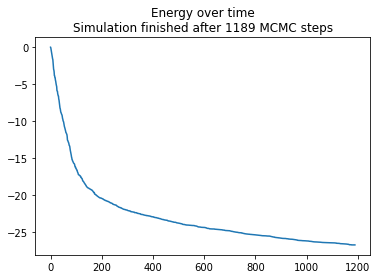

In [27]:
plt.plot(range(cloth.step + 1), cloth.E_data)
plt.title(f'Energy over time\nSimulation finished after {cloth.step} MCMC steps')
plt.show()

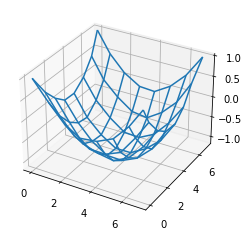

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = cloth.get_world_coords()
wf_plot = ax.plot_wireframe(X.reshape(cloth.N, cloth.N).T, Y.reshape(cloth.N, cloth.N).T, Z.reshape(cloth.N, cloth.N).T)
plt.show()


### Repeat the experiment, but now include a ''cooling schedule''. Try halving the temperature each time the system reaches equilibrium. Do three successive halvings. Plot the different final configurations and comment on their differences. ###

I repeat the above simulation with 3 temperature halvings. The plots for the final configurations are plotted below. Much of the noise is smoothed out over the course of the cooling schedule.

Interestingly, this is a good way to drastically speed up the simulation. In addition to halving the temperature, I also quarter my threshold for equilbirum. Recall that above I had an initial threshold for equilbirium of 1e-9. In this simulation I begin with a threshold of 1e-2, and decrease it over 3 cooling steps to approximately 3.9e-9. However, in the above simulation it takes around 1,100 MCMC steps to reach equilbrium, whereas in this simulation it only takes around 400 steps to reach equilbrium with 3 cooling steps.

In [29]:
cloth = Cloth(corners, kT=1e-3, N=L, thresh=1e-2)
data = cloth.simulate_with_cooling(3)

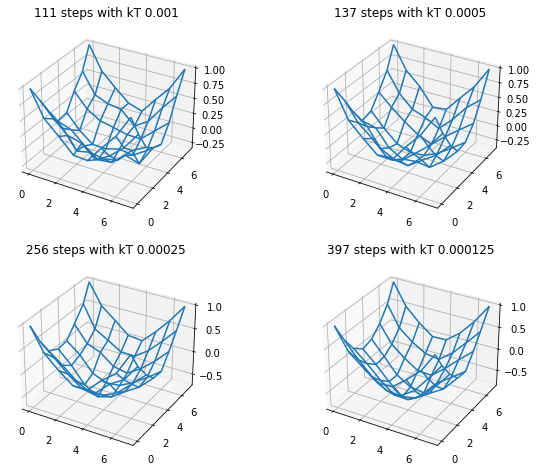

In [30]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221, projection='3d')
kt1, steps_1 = data[0][0], data[0][1]
x1, y1, z1 = data[0][2], data[0][3], data[0][4]
ax1.plot_wireframe(x1.reshape(cloth.N, cloth.N).T, y1.reshape(cloth.N, cloth.N).T,
                   z1.reshape(cloth.N, cloth.N).T)
ax1.set_title(f'{steps_1} steps with kT {kt1}')
ax2 = fig.add_subplot(222, projection='3d')

kt2, steps_2 = data[1][0], data[1][1]
x2, y2, z2 = data[1][2], data[1][3], data[1][4]
ax2.plot_wireframe(x2.reshape(cloth.N, cloth.N).T, y2.reshape(cloth.N, cloth.N).T,
                   z2.reshape(cloth.N, cloth.N).T)
ax2.set_title(f'{steps_2} steps with kT {kt2}')

ax3 = fig.add_subplot(223, projection='3d')
kt3, steps_3 = data[2][0], data[2][1]
x3, y3, z3 = data[2][2], data[2][3], data[2][4]
ax3.plot_wireframe(x3.reshape(cloth.N, cloth.N).T, y3.reshape(cloth.N, cloth.N).T,
                   z3.reshape(cloth.N, cloth.N).T)
ax3.set_title(f'{steps_3} steps with kT {kt3}')

ax4 = fig.add_subplot(224, projection='3d')
kt4, steps_4 = data[3][0], data[3][1]
x4, y4, z4 = data[3][2], data[3][3], data[3][4]
ax4.plot_wireframe(x4.reshape(cloth.N, cloth.N).T, y4.reshape(cloth.N, cloth.N).T,
                   z4.reshape(cloth.N, cloth.N).T)
ax4.set_title(f'{steps_4} steps with kT {kt4}')

plt.show()

### (b) Plot the energy per particle vs the temperature at various lattice sizes. Explain what you find. ###

Below, I run 4 simulations with 

In [70]:
# Run the simulation with lattice sizes 4, 6, 8, 10
L4_data = list()
L6_data = list()
L8_data = list()
L10_data = list()

# Run simulations with the following temp values
temps = np.linspace(1e-4, 1e-1, 10)
for t in temps:
    cloth_1 = Cloth(corners, N=4, kT=t)
    cloth_2 = Cloth(corners, N=6, kT=t)
    cloth_3 = Cloth(corners, N=8, kT=t)
    cloth_4 = Cloth(corners, N=10, kT=t)
    # Run each simulation for 500 MCMC steps
    for i in range(200):
        cloth_1.do_mcmc_step()
        cloth_2.do_mcmc_step()
        cloth_3.do_mcmc_step()
        cloth_4.do_mcmc_step()
    # Save the data for plotting
    L4_data.append(cloth_1.E_per_particle[-1])
    L6_data.append(cloth_2.E_per_particle[-1])
    L8_data.append(cloth_3.E_per_particle[-1])
    L10_data.append(cloth_4.E_per_particle[-1])

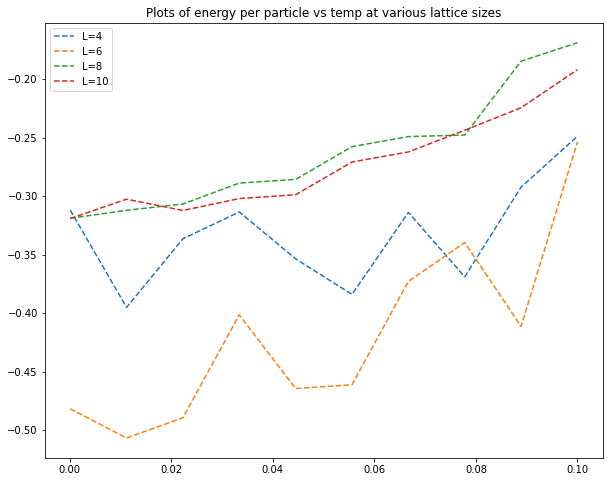

In [71]:
# Plot the 4 simulations
fig = plt.figure(figsize=(10,8))
plt.plot(temps, L4_data, '--')
plt.plot(temps, L6_data, '--')
plt.plot(temps, L8_data, '--')
plt.plot(temps, L10_data, '--')
plt.title('Plots of energy per particle vs temp at various lattice sizes')
plt.legend(['L=4', 'L=6', 'L=8', 'L=10'])

plt.show()